In [77]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
# not working for me
#from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop', 'dislike', 'peace', 'rock']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

In [85]:
annotations = dict()
validation_annotations = dict()

for condition in CONDITIONS:
    with open(f'_dataset/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

    with open(f'annot-bierschneider.json') as ff:
        validation_annotations[condition] = json.load(ff)


In [86]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

In [87]:
def load_images(annotation, path):
# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
  images = [] # stores actual image data
  labels = [] # stores labels (as integer - because this is what our network needs)
  label_names = [] # maps label ints to their actual categories so we can understand predictions later

  for condition in CONDITIONS:
      #for filename in tqdm(os.listdir(condition)):
      for filename in os.listdir(f"./{path}/{condition}"):
          # extract unique ID from file name
          UID = filename.split('.')[0]
          img = cv2.imread(f'./{path}/{condition}/{filename}')

          # get annotation from the dict we loaded earlier
          try:
              annot = annotation[condition][UID]
          except Exception as e:
              print(e)
              continue
          
          # iterate over all hands annotated in the image
          for i, bbox in enumerate(annot['bboxes']):
              # annotated bounding boxes are in the range from 0 to 1
              # therefore we have to scale them to the image size
              x1 = int(bbox[0] * img.shape[1])
              y1 = int(bbox[1] * img.shape[0])
              w = int(bbox[2] * img.shape[1])
              h = int(bbox[3] * img.shape[0])
              x2 = x1 + w
              y2 = y1 + h
              
              # crop image to the bounding box and apply pre-processing
              crop = img[y1:y2, x1:x2]
              preprocessed = preprocess_image(crop)
              
              # get the annotated hand's label
              # if we have not seen this label yet, add it to the list of labels
              label = annot['labels'][i]
              if label not in label_names:
                  label_names.append(label)
              
              label_index = label_names.index(label)
              
              images.append(preprocessed)
              labels.append(label_index)
  
  return images, labels, label_names

In [88]:
images, labels, label_names = load_images(annotations, "_dataset")
val_images, val_labels, val_label_names = load_images(validation_annotations, "_bierschneider_dataset")

In [89]:
X_train = images
y_train = labels
X_test = val_images
y_test = val_labels


X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(1627, 64, 64, 3) (16, 64, 64, 3) (1627, 6) (16, 6)


In [130]:
# variables for hyperparameters
batch_size = 16
epochs = 50
num_classes = len(label_names)
activation = 'tanh'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=4)

In [131]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
102/102 [==============================] - 10s 87ms/step - loss: 1.7629 - accuracy: 0.2489 - val_loss: 1.9390 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/50
102/102 [==============================] - 9s 91ms/step - loss: 1.2742 - accuracy: 0.5071 - val_loss: 2.2156 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 3/50
102/102 [==============================] - 10s 93ms/step - loss: 0.7230 - accuracy: 0.7363 - val_loss: 2.1492 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/50
102/102 [==============================] - 9s 84ms/step - loss: 0.4666 - accuracy: 0.8445 - val_loss: 2.6385 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 5/50
102/102 [==============================] - 9s 83ms/step - loss: 0.3093 - accuracy: 0.9041 - val_loss: 2.5162 - val_accuracy: 0.5000 - lr: 2.0000e-04


In [132]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_13 (RandomFlip)  (None, 64, 64, 3)        0         
                                                                 
 random_contrast_10 (RandomC  (None, 64, 64, 3)        0         
 ontrast)                                                        
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 6, 6, 32)       

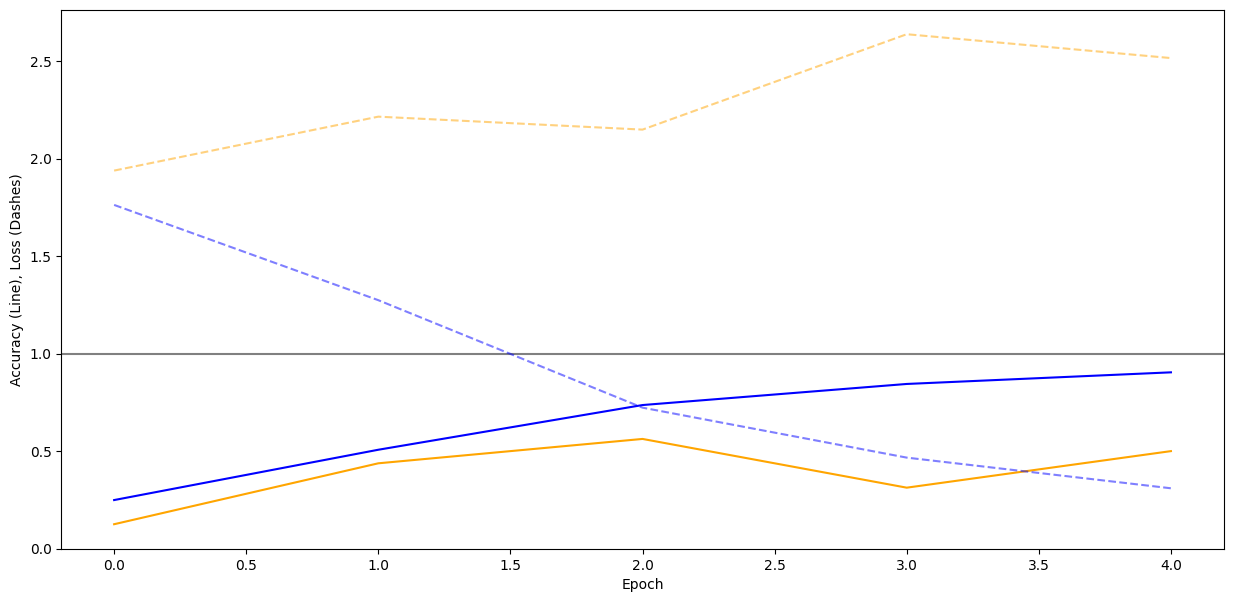

In [133]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

1/1 [==============================] - 0s 99ms/step
before [[8.0132300e-01 6.5964891e-04 2.8637932e-03 1.4912119e-04 1.9143039e-01
  3.5740875e-03]
 [9.8774016e-01 1.5696265e-03 5.9811077e-03 7.9804930e-05 3.7271448e-03
  9.0201595e-04]
 [9.7122198e-01 3.4021414e-04 2.6482767e-03 1.3563786e-04 2.5199641e-02
  4.5413739e-04]
 [7.9282381e-02 4.3130750e-03 9.1403210e-01 5.7071407e-04 1.4136211e-03
  3.8812790e-04]
 [6.7468114e-02 8.4546153e-03 9.1935915e-01 1.9215429e-03 2.2981565e-03
  4.9847062e-04]
 [1.1741315e-02 1.9601563e-03 9.5061672e-01 1.9051217e-02 1.6019505e-02
  6.1119592e-04]
 [9.3648788e-03 7.5205511e-01 3.0858761e-02 1.4283124e-01 1.6650153e-02
  4.8239756e-02]
 [1.4759010e-01 5.2309468e-02 5.9643042e-01 1.3974033e-02 1.2028524e-01
  6.9410749e-02]
 [3.7809433e-03 6.9624019e-01 6.4640900e-04 2.6003855e-01 1.2648811e-02
  2.6645234e-02]
 [1.2396164e-03 7.5098090e-02 1.8158081e-03 9.1506982e-01 4.0135123e-03
  2.7630921e-03]
 [4.6029342e-03 7.4901839e-04 5.0144847e-03 7.42261

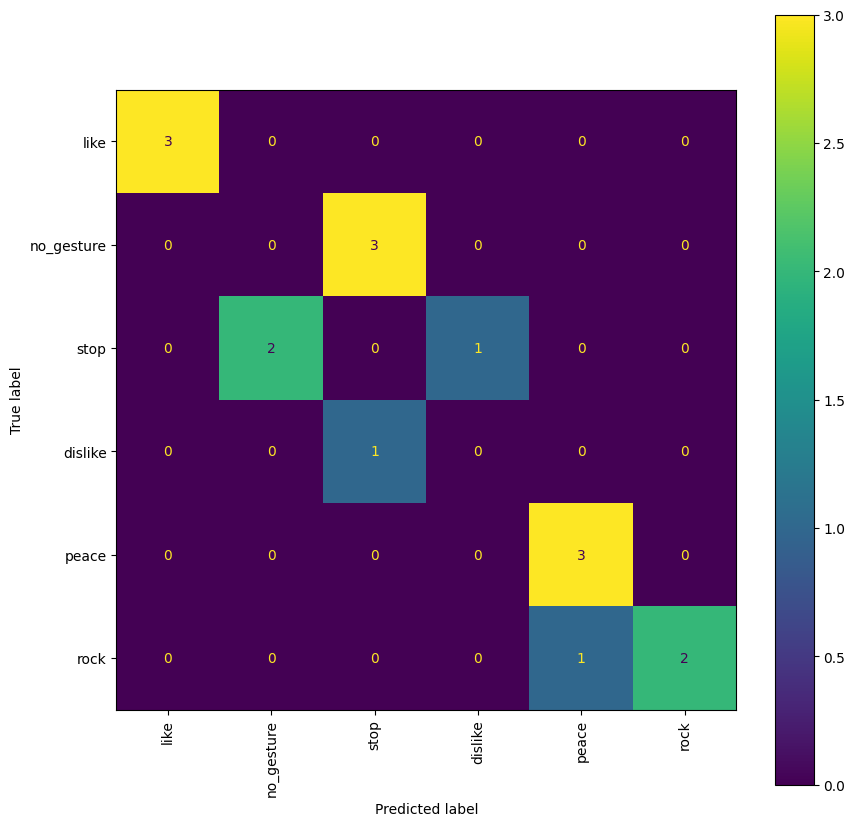

In [134]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass